## Trabajo Práctico N°1: modelo predictivo de tarifas de Uber
Integrantes: Sebastian Palacio, Juana Chies Doumecq

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [30]:
import pandas as pd
import numpy as np
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

from haversine import haversine

In [31]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path) 

In [32]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [33]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  int64              
 1   date               200000 non-null  object             
 2   fare_amount        200000 non-null  float64            
 3   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 4   pickup_longitude   200000 non-null  float64            
 5   pickup_latitude    200000 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    200000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(1)
memory usage: 13.7+ MB


**Manejo de valores nulos**

In [35]:
#Primero verificamos las columnas que contienen valores nulos

df.isnull().sum()

df[df.isnull().any(axis=1)] 

df = df.dropna()
df.shape

(199999, 9)

**Feature engineering: creación de nuevas variables**

In [36]:
# Nuevas variables dependiendo el tipo de Uber

df['normal_uber'] = ((df['passenger_count'] >= 1) & (df['passenger_count'] <= 4)).astype(int)
df['uber_eats'] = (df['passenger_count'] == 0).astype(int)

In [37]:
# Filtramos según coordenadas aproximadas del estado de Nueva York

lat_min, lat_max = 40.5, 41.0
lon_min, lon_max = -74.3, -73.6

df = df[
    (df['pickup_latitude'].between(lat_min, lat_max)) &
    (df['pickup_longitude'].between(lon_min, lon_max)) &
    (df['dropoff_latitude'].between(lat_min, lat_max)) &
    (df['dropoff_longitude'].between(lon_min, lon_max))
]

In [38]:
# Nueva variable con la distancia recorrida

df['distance_km'] = df.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ),
    axis=1
)

In [39]:
# Nueva variable dependiendo si es de noche (tomando como noche desde las 00hs y 7hs)

hours = df['pickup_datetime'].dt.hour

df['is_night'] = [1 if hour <= 7 and hour >= 0 else 0 for hour in hours]

In [40]:
# Nueva variable dependiendo si es día de semana (tomando como fin de semana de jueves a domingo)

dias_semana = df['pickup_datetime'].dt.dayofweek

df['weekday'] = [1 if day <= 4 else 0 for day in dias_semana]

In [41]:
# Nueva variable dependiendo si es feriado

anios = df['pickup_datetime'].dt.year.unique()

us_holidays = holidays.country_holidays('US', years=anios)

df['is_holiday'] = df['pickup_datetime'].dt.date.isin(us_holidays).astype(int)

In [ ]:
# Nueva variable con el precio por km (usada después para imputar)
df["price_km"] = df["fare_amount"] / df["distance_km"]

moda_pasajeros = df.loc[(df['passenger_count'] >= 0) & (df['passenger_count'] <= 6), 'passenger_count'].mode()[0]
df.loc[(df['passenger_count'] < 0) | (df['passenger_count'] > 6), 'passenger_count'] = moda_pasajeros

# Filtramos la distancia según si el precio por kilómetro está entre 0.5 y 10 dólares
tarifa_mediana = df.loc[(df["price_km"] >= 0.5) & (df["price_km"] <= 10), "price_km"].median()
precios_atipicos = (df["price_km"] < 0.5) | (df["price_km"] > 10)
df.loc[precios_atipicos, "fare_amount"] = df.loc[precios_atipicos, "distance_km"] * tarifa_mediana

**Selección de variables útiles**

In [43]:
columnas_significativas = ['fare_amount', 'normal_uber', 'uber_eats', 'distance_km', 'is_night', 'weekday', 'is_holiday']

**División de datos train-test**

In [44]:
df_div = df[columnas_significativas]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_div.drop(columns='fare_amount'), 
                                                    df_div['fare_amount'], 
                                                    test_size=0.2, 
                                                    random_state=42)

# y_train = X_train['fare_amount']
# y_test  = X_test['fare_amount']

# X_train = X_train.drop('fare_amount', axis=1)
# X_test  = X_test.drop('fare_amount', axis=1)

In [46]:
X_train.describe()

,normal_uber,uber_eats,distance_km,is_night,weekday,is_holiday
count,156499.000000,156499.000000,156499.000000,156499.000000,156499.000000,156499.000000
mean,0.904888,0.003495,3.310822,0.186519,0.716279,0.022703
std,0.293371,0.059017,3.566768,0.389526,0.450804,0.148955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.255447,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.155686,0.000000,1.000000,0.000000
75%,1.000000,0.000000,3.908068,0.000000,1.000000,0.000000
max,1.000000,1.000000,36.687456,1.000000,1.000000,1.000000


**Visualizacion de datos**

In [47]:
# Gráficaremos variables de entrenamiento y cuantitativas

train = X_train[['distance_km']].copy()
train['fare_amount'] = y_train.copy()

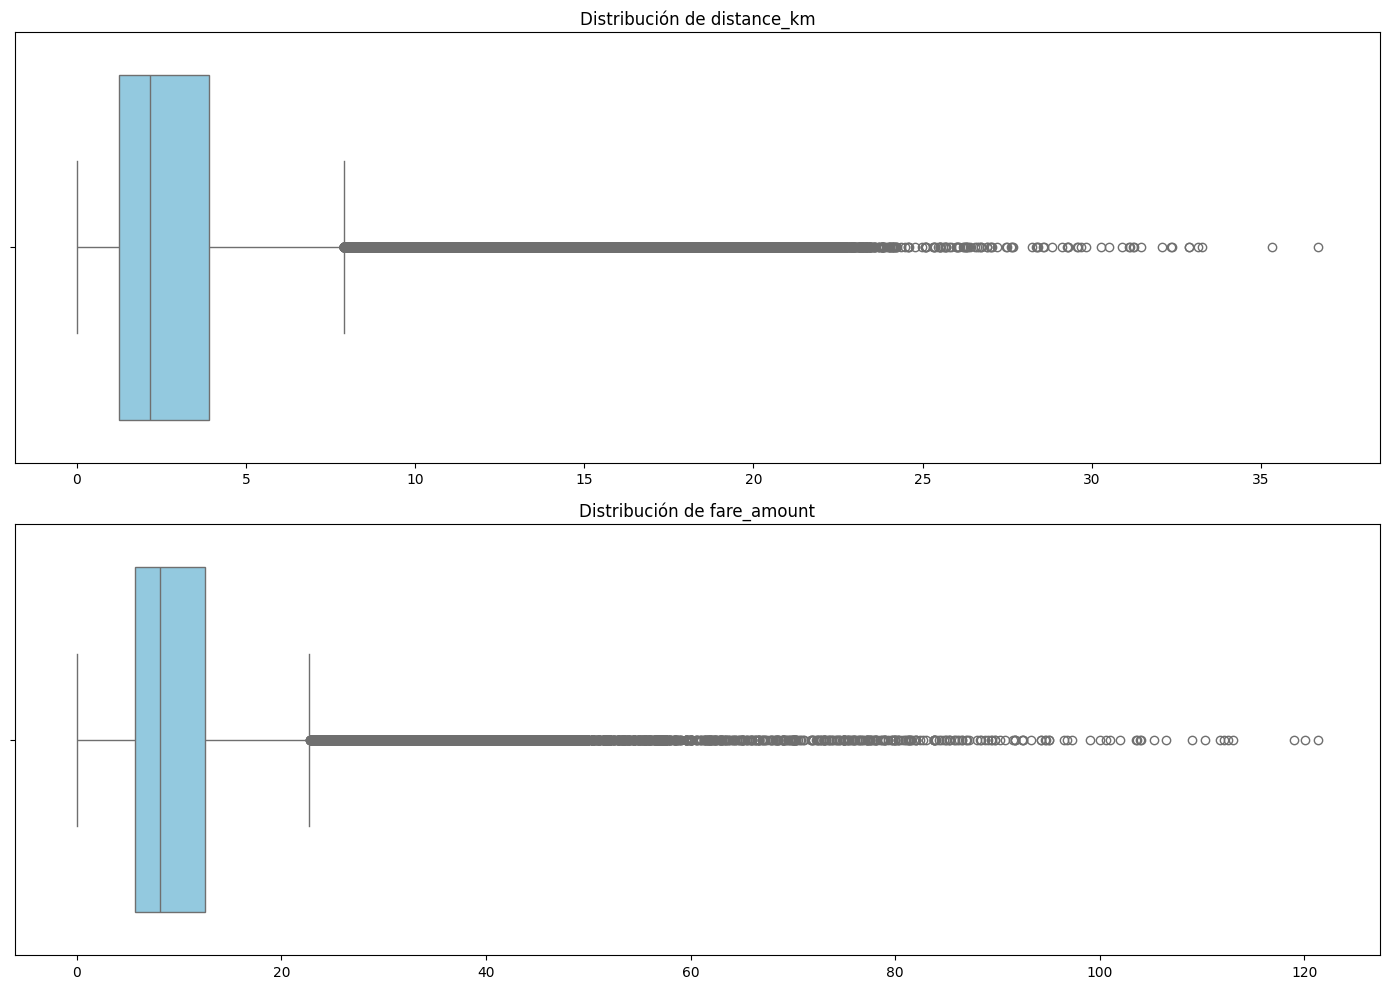

In [48]:
fig, axes = plt.subplots(nrows=len(train.columns), figsize=(14, 5*len(train.columns)))

if len(train.columns) == 1:
    axes = [axes]

for i, var in enumerate(train.columns):
    sns.boxplot(data=train, x=var, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

En este gráfico se observa la distribución de las variables numéricas del conjunto de datos. La variable con mayor dispersión es el monto de la tarifa, que presenta numerosos valores atípicos muy por encima del rango principal. Sin embargo, ya se limpiaron los valores atípicos reales, y estos son outliers que consideramos válidos.

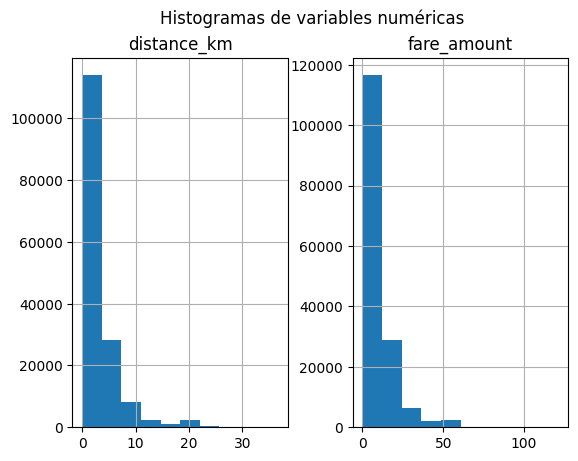

In [49]:
train.hist()
plt.suptitle("Histogramas de variables numéricas")
plt.show()

En los histogramas se observa que tanto el monto de la tarifa (fare_amount) como la distancia recorrida (distance_km) presentan una distribución asimétrica positiva, con una gran concentración de valores en los rangos bajos y una larga cola hacia la derecha. Esto indica que la mayoría de los viajes son cortos y económicos, mientras que los recorridos largos y costosos son mucho menos frecuentes. También se pueden identificar algunos valores atípicos que podrían corresponder a trayectos excepcionales. En conjunto, la forma de las distribuciones refuerza la idea de que los viajes típicos se concentran en desplazamientos de corta distancia dentro del área urbana.

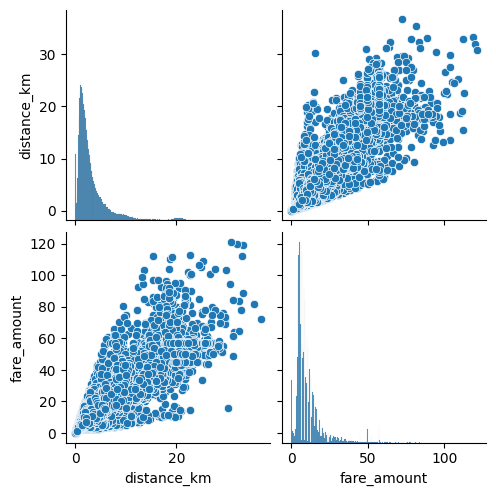

In [50]:
sns.pairplot(train);

En la matriz de dispersión se observa una relación positiva clara entre el monto de la tarifa (fare_amount) y la distancia recorrida (distance_km), lo que indica que a mayor distancia, mayor es el costo del viaje, una relación esperable en este tipo de servicio. Además, ambas variables presentan una distribución asimétrica hacia la derecha, con una gran concentración de valores bajos y pocos casos con montos o distancias elevadas. En conjunto, los gráficos confirman que la distancia es el principal factor asociado al valor de la tarifa, mientras que otras variables no incluidas aquí podrían influir de manera más específica o no lineal.

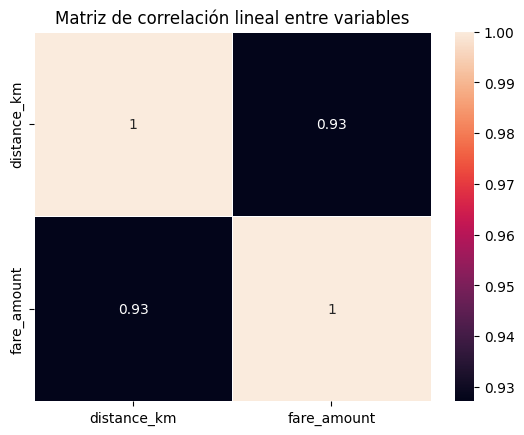

In [51]:
corrmat = train.corr()

sns.heatmap(corrmat, vmax=1, annot=True, linewidths=.5)
plt.title('Matriz de correlación lineal entre variables')
plt.show()

En este Heatmap de Correlación Lineal se observa que la variable fare_amount tiene una correlación muy alta y positiva con distance_km (0.93), lo que indica que el precio está fuertemente determinado por la distancia recorrida. 

**Escalado de datos**

In [52]:
X_train.describe()

,normal_uber,uber_eats,distance_km,is_night,weekday,is_holiday
count,156499.000000,156499.000000,156499.000000,156499.000000,156499.000000,156499.000000
mean,0.904888,0.003495,3.310822,0.186519,0.716279,0.022703
std,0.293371,0.059017,3.566768,0.389526,0.450804,0.148955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.255447,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.155686,0.000000,1.000000,0.000000
75%,1.000000,0.000000,3.908068,0.000000,1.000000,0.000000
max,1.000000,1.000000,36.687456,1.000000,1.000000,1.000000


In [53]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [54]:
X_test.head()

,normal_uber,uber_eats,distance_km,is_night,weekday,is_holiday
62582,1,0,2.339026,1,0,0
37318,1,0,2.029586,0,1,0
187993,1,0,2.547887,0,1,0
21344,1,0,1.487889,0,1,0
24254,1,0,0.000000,1,1,0


## Regresión lineal

In [55]:
modelo_lineal = make_pipeline(StandardScaler(with_mean=True), LinearRegression())

In [56]:
modelo_lineal.fit(X = X_train, y = y_train)

,steps,"[('standardscaler', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


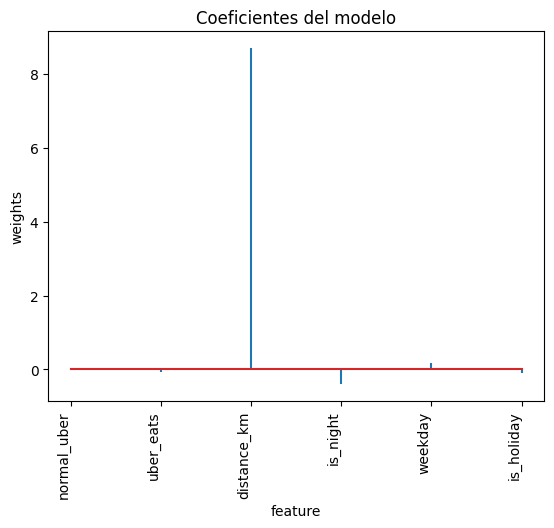

In [57]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_lineal.steps[1][1].coef_.flatten()}
                  )

fig, ax = plt.subplots()
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Coeficientes del modelo')
plt.show()

En este gráfico de coeficientes del modelo se observa que la variable distance_km es la que tiene un peso claramente dominante y positivo, lo que confirma que la distancia recorrida es el principal determinante del precio.

In [58]:
# Predicciones test

predicciones = modelo_lineal.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([ 7.45355493,  8.09723065,  9.36110372,  6.77630356,  2.10657673,
        5.10995787, 11.20324561,  5.49277132,  9.49632909, 24.9215639 ])

In [59]:
rmse_ols = np.sqrt(mean_squared_error(
                    y_true  = y_test,
                    y_pred  = predicciones
                    ))

print(f"El error (rmse) de test es: {rmse_ols}")

El error (rmse) de test es: 3.518156471730886


In [60]:
R2 = metrics.r2_score(y_test, predicciones)

print(f'R2 en el modelo de regresión lineal: {R2}')

R2 en el modelo de regresión lineal: 0.8621442066161052


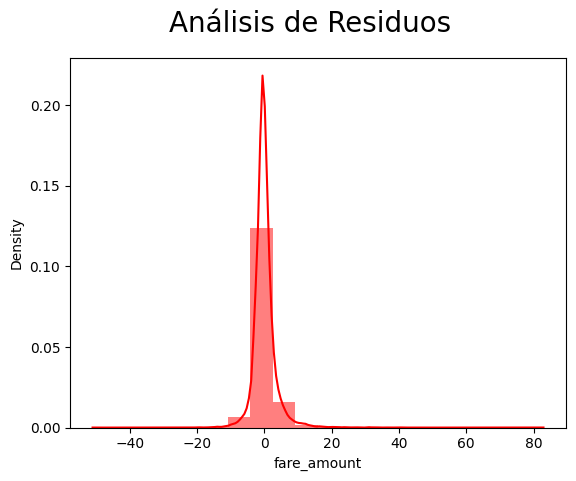

In [61]:
fig = plt.figure()
  
sns.histplot((y_test - predicciones.reshape(y_test.shape)), color="red", kde=True, stat="density", linewidth=0,bins=20)
fig.suptitle('Análisis de Residuos', fontsize = 20)    
plt.show()

Este gráfico muestra la distribución de los residuos del modelo. Se observa que la mayoría de los valores se concentran en torno a cero, lo cual es deseable porque indica que el modelo no tiene un sesgo sistemático en sus predicciones.

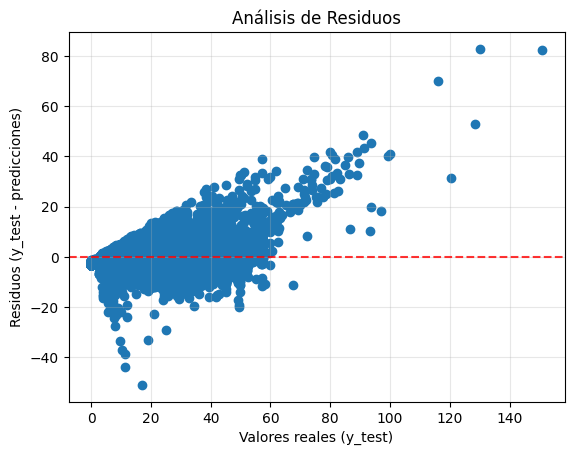

In [62]:
residuos = y_test - predicciones

plt.scatter(y_test, residuos)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)
plt.title('Análisis de Residuos')
plt.xlabel('Valores reales (y_test)')
plt.ylabel('Residuos (y_test - predicciones)')
plt.grid(True, alpha=0.3)
plt.show()

Este gráfico de dispersión muestra los residuos frente a los valores reales. La mayor parte de los puntos se agrupa alrededor de la línea horizontal en cero, lo cual indica que el modelo predice de forma razonablemente buena en la mayoría de los casos.

## Modelos Gradiente-Descendiente

In [63]:
def mse_loss(y_true, y_pred): 
    return np.mean((y_true - y_pred) ** 2)

def mse_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(2/n) * (X.T @ (y_true - y_pred))

def mae_loss(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

def mae_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(1/n) * (X.T @ np.sign(y_true - y_pred))

In [64]:
def plot_loss(train_errors, val_errors):
    # gráfico de errores
    plt.figure(figsize=(12, 4))
    plt.plot(train_errors, label='train_loss')
    plt.plot(val_errors, label='val_loss')
    plt.xlabel('Iteración')
    plt.ylabel('Error')
    plt.title('Evolución de función de pérdida vs iteraciones')
    plt.legend()
    plt.grid(True)
    plt.show()

### Gradiente-Descendiente

In [65]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient):
    """
    Gradient Descent para regresión lineal con tracking de errores y coeficientes.
    
    Parámetros:
    -----------
    X_train : ndarray de shape (n, m)
        Datos de entrenamiento.
    y_train : ndarray de shape (n, 1)
        Etiquetas de entrenamiento.
    X_val : ndarray de shape (p, m)
        Datos de validación.
    y_val : ndarray de shape (p, 1)
        Etiquetas de validación.
    lr : float, opcional (default=0.01)
        Tasa de aprendizaje.
    epochs : int, opcional (default=100)
        Número de iteraciones.
    grad_fn : (default = mse_gradient)
        Función de pérdida.

    Devuelve:
    --------
    W : ndarray de shape (m+1, 1)
        Pesos finales aprendidos.
    """

    y_train = np.array(y_train).reshape(-1, 1)
    y_val = np.array(y_val).reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W

        error_train = y_train - y_pred_train
        error_val = y_val - y_pred_val

        train_mse = np.mean(error_train ** 2)
        val_mse = np.mean(error_val ** 2)

        train_errors.append(train_mse)
        val_errors.append(val_mse)

        gradient = grad_fn(X_train, y_train, y_pred_train)
        W -= lr * gradient

        coef_history.append(W.flatten())


    y_pred_train_final = X_train @ W
    y_pred_val_final = X_val @ W

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val_final))

    train_r2 = r2_score(y_train, y_pred_train_final)
    val_r2 = r2_score(y_val, y_pred_val_final)

    metrics = {"train_rmse": train_rmse, 
               "val_rmse": val_rmse,
               "train_r2": train_r2, 
               "val_r2": val_r2}

    plot_loss(train_errors, val_errors)

    return W, metrics

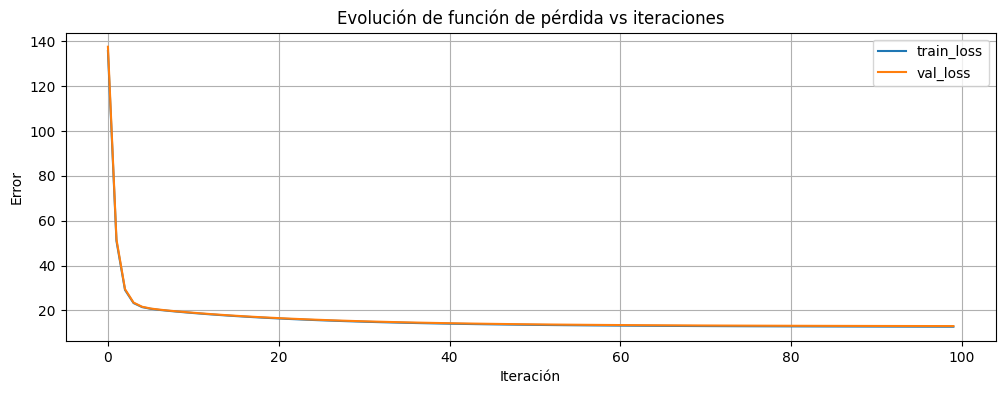

Pesos finales: [0.75522381 1.59934678 0.896339   2.48553719 0.47945607 0.22275879
 0.62016125]
Métricas: {'train_rmse': np.float64(3.57173601548406), 'val_rmse': np.float64(3.611806910683971), 'train_r2': 0.8538268769474527, 'val_r2': 0.8547073084147639}


In [66]:
W_gradient_descent, metrics_gradient_descent = gradient_descent(X_train, y_train, X_test, y_test)

print("Pesos finales:", W_gradient_descent.flatten())
print("Métricas:", metrics_gradient_descent)

En este gráfico se observa la evolución de la función de pérdida durante el entrenamiento y la validación. Ambas curvas descienden rápidamente en las primeras iteraciones y luego se estabilizan en valores bajos y casi idénticos. Esto indica que el modelo aprendió de manera efectiva sin señales de sobreajuste.

### Descenso de gradiente estocástico

In [67]:
def stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient, batch_size=1):
    """
    Stochastic Gradient Descent (SGD) para regresión lineal con tracking de errores y coeficientes.
    
    Parámetros:
    -----------
    X_train, y_train, X_val, y_val : datos de entrenamiento y validación
    lr : tasa de aprendizaje
    epochs : número de pasadas completas sobre el dataset
    grad_fn : función de gradiente (default = mse_gradient)
    batch_size : tamaño del lote (1 = SGD puro, >1 = Mini-batch SGD)

    Devuelve:
    ---------
    W : ndarray de shape (m+1, 1)
        Pesos finales aprendidos.
    """

    y_train = np.array(y_train).reshape(-1, 1)
    y_val = np.array(y_val).reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        indices = np.random.permutation(n)

        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())

    
    y_pred_train_final = X_train @ W
    y_pred_val_final = X_val @ W

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val_final))

    train_r2 = r2_score(y_train, y_pred_train_final)
    val_r2 = r2_score(y_val, y_pred_val_final)

    metrics = {
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "train_r2": train_r2,
        "val_r2": val_r2
    }

    plot_loss(train_errors, val_errors)

    return W, metrics

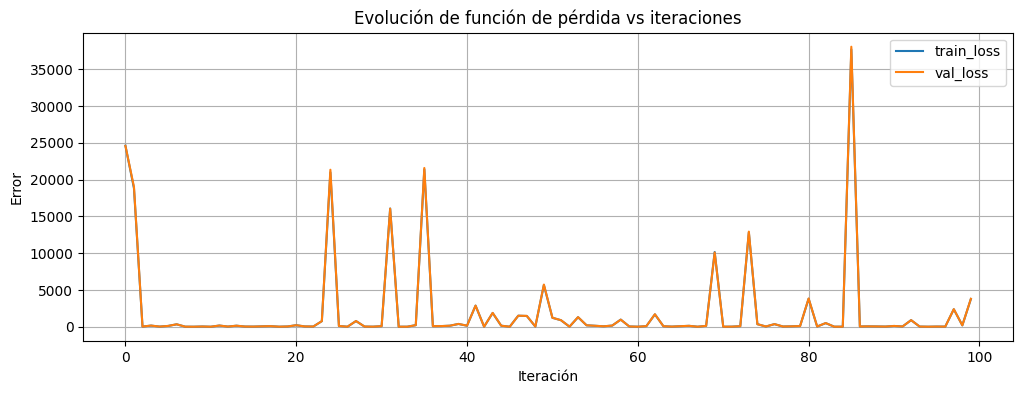

Pesos finales: [  3.79000732  -1.53476021  -3.65360334  11.22925208 -11.2105038
  33.23152609  13.06752185]
Métricas: {'train_rmse': np.float64(61.48776623526379), 'val_rmse': np.float64(61.6840005380729), 'train_r2': -42.31978095755254, 'val_r2': -41.37793442106726}


In [68]:
W_stochastic, metrics_stochastic = stochastic_gradient_descent(X_train, y_train, X_test, y_test)

print("Pesos finales:", W_stochastic.flatten())
print("Métricas:", metrics_stochastic)

En este gráfico se aprecia un comportamiento anómalo de la función de pérdida. Tanto en entrenamiento como en validación los valores permanecen cercanos a cero en la mayoría de las iteraciones, pero alrededor de la iteración 40 aparece un pico extremo que dispara el error a un valor muy elevado.

### Descenso de gradiente en minilotes

In [69]:
def mini_batch_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, batch_size=32, grad_fn=mse_gradient):
    """
    Mini-Batch Gradient Descent (MBGD) para regresión lineal con tracking de errores y coeficientes.
    Notar que esta función se puede usar directamente para los tres casos: si batch_size = 1, es el caso de SGD.
    Si batch_size = len(X), es el caso de GD.
    
    Parámetros:
    -----------
    X_train, y_train, X_val, y_val : datos de entrenamiento y validación
    lr : tasa de aprendizaje
    epochs : número de pasadas completas sobre el dataset
    batch_size : tamaño de cada mini-lote
    grad_fn : función de gradiente (default = mse_gradient)

    Devuelve:
    ---------
    W : ndarray de shape (m+1, 1)
        Pesos finales aprendidos.
    """

    y_train = np.array(y_train).reshape(-1, 1)
    y_val = np.array(y_val).reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        indices = np.random.permutation(n)

        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())


    y_pred_train_final = X_train @ W
    y_pred_val_final = X_val @ W

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val_final))

    train_r2 = r2_score(y_train, y_pred_train_final)
    val_r2 = r2_score(y_val, y_pred_val_final)

    metrics = {
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "train_r2": train_r2,
        "val_r2": val_r2
    }

    plot_loss(train_errors, val_errors)

    return W, metrics

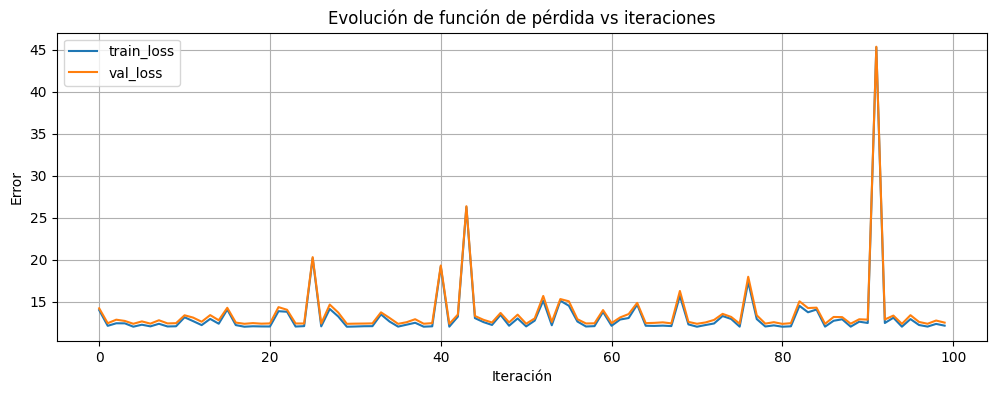

Pesos finales: [ 2.72288584 -0.17938603 -1.16932167  2.41098976 -0.99360082  0.32753401
 -0.63237998]
Métricas: {'train_rmse': np.float64(3.487008047191177), 'val_rmse': np.float64(3.538648412396648), 'train_r2': 0.8606795979077924, 'val_r2': 0.8605336132001764}


In [70]:
W_mini_batch, metrics_mini_batch = mini_batch_gradient_descent(X_train, y_train, X_test, y_test)

print("Pesos finales:", W_mini_batch.flatten())
print("Métricas:", metrics_mini_batch)

En el gráfico observamos la evolución de la función de pérdida durante el entrenamiento y la validación del modelo a lo largo de 100 iteraciones. Se observa que ambas curvas siguen un comportamiento similar, lo que indica que no hay un sobreajuste significativo. Sin embargo, las pérdidas presentan bastante variabilidad, con picos marcados en algunas iteraciones, lo que sugiere que el modelo podría beneficiarse de un mayor ajuste de hiperparámetros o de técnicas de estabilización en el entrenamiento.

## Métodos de Regularización

In [71]:
# Gráfico de coeficientes del modelo en funcion de la regularización

def grafico_coef_regularizacion(alphas, coefs, feature_names):
    coefs = np.array(coefs).T 

    fig, ax = plt.subplots()
    for coef, name in zip(coefs, feature_names):
        ax.plot(alphas, coef, label=name)

    ax.set_xscale('log')
    ax.set_ylim([-0.5, None])
    ax.set_xlabel('alpha')
    ax.set_ylabel('Coeficientes')
    ax.legend()
    ax.set_title('Coeficientes del modelo en función de la regularización')
    plt.show()

In [72]:
# Gráfico de parámetros del modelo

def grafico_coef(df_coeficientes):
    fig, ax = plt.subplots()
    ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
    plt.xticks(rotation=90, ha='right', size=10)
    ax.set_xlabel('features')
    ax.set_ylabel('parámetros')
    ax.set_title('Parámetros del modelo')
    plt.show()

In [73]:
# Gráficos de residuos del modelo

def graficos_residuos(y_test, predicciones):

    fig = plt.figure()
    sns.histplot((y_test - predicciones.reshape(y_test.shape)), kde=True, stat="density", linewidth=0,bins=20)
    fig.suptitle('Análisis de Residuos', fontsize = 20)    
    plt.show()

    residuos = y_test - predicciones
    plt.scatter(y_test, residuos)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    plt.title('Análisis de Residuos')
    plt.xlabel('Valores reales (y_test)')
    plt.ylabel('Residuos (y_test - predicciones)')
    plt.grid(True, alpha=0.3)
    plt.show()

### Lasso Regression

In [74]:
modelo_lasso = make_pipeline(StandardScaler(),
                        LassoCV(
                           alphas=np.logspace(-3, 6, 200),
                           cv=10
                        ))

_ = modelo_lasso.fit(X_train, y_train)

mod_lasso = modelo_lasso.steps[1][1]

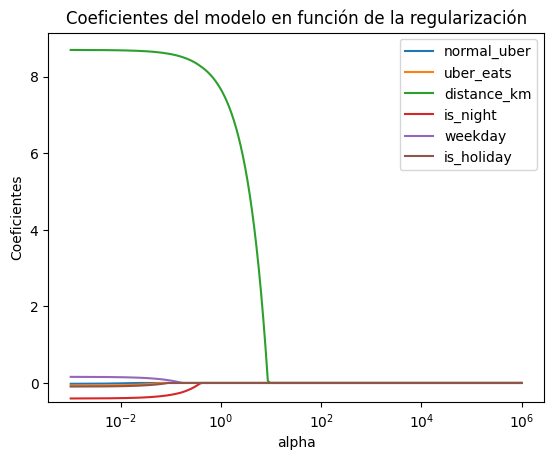

In [75]:
alphas_lasso = mod_lasso.alphas
coefs_lasso = []

for alpha in alphas_lasso:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs_lasso.append(modelo_aux.steps[1][1].coef_.flatten())

grafico_coef_regularizacion(alphas_lasso, coefs_lasso, X_train.columns)

El gráfico muestra cómo varían los coeficientes del modelo en función del parámetro de regularización alpha. Se observa que la variable con mayor peso es la distancia en kilómetros, lo que confirma su importancia en la predicción. A medida que aumenta la regularización, los coeficientes de todas las variables tienden a acercarse a cero, lo que reduce la complejidad del modelo y evita sobreajuste. Este comportamiento es consistente con el efecto esperado de la regularización, priorizando las variables más relevantes y descartando aquellas con menor impacto.

In [76]:
print(f"Mejor valor de alpha encontrado: {mod_lasso.alpha_}")

Mejor valor de alpha encontrado: 0.001


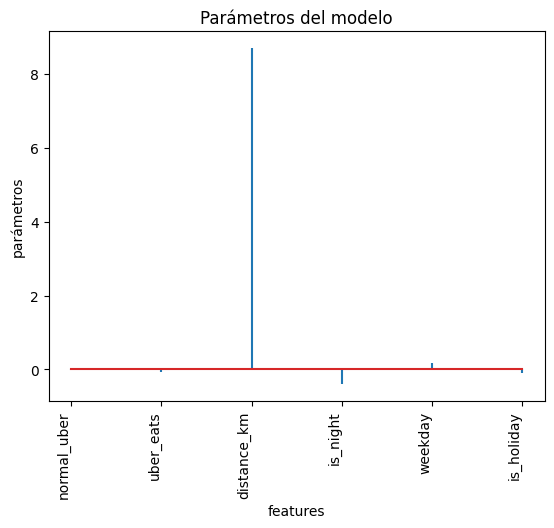

In [77]:
df_coeficientes_lasso = pd.DataFrame(
                            {'predictor': X_train.columns,
                            'coef': mod_lasso.coef_.flatten()}
                     )

grafico_coef(df_coeficientes_lasso)

El gráfico de parámetros del modelo muestra que la variable con mayor peso es la distancia en kilómetros, con un coeficiente significativamente más alto que el resto. Las demás variables presentan valores muy cercanos a cero, lo que refleja un impacto mínimo en las predicciones. Esto confirma que la distancia es el factor principal que determina el resultado del modelo, mientras que las otras características aportan de manera marginal.

In [78]:
y_pred_lasso = modelo_lasso.predict(X_test)

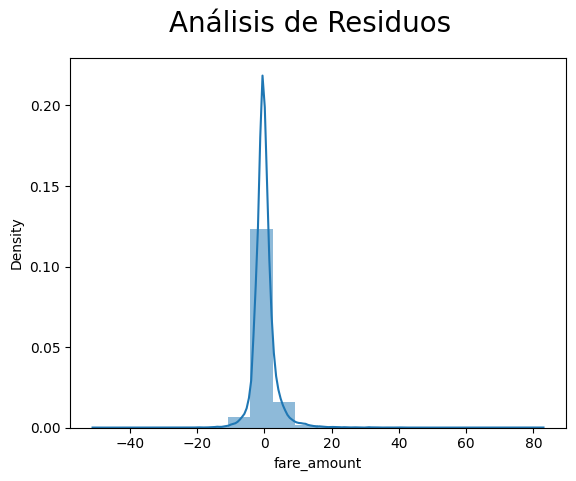

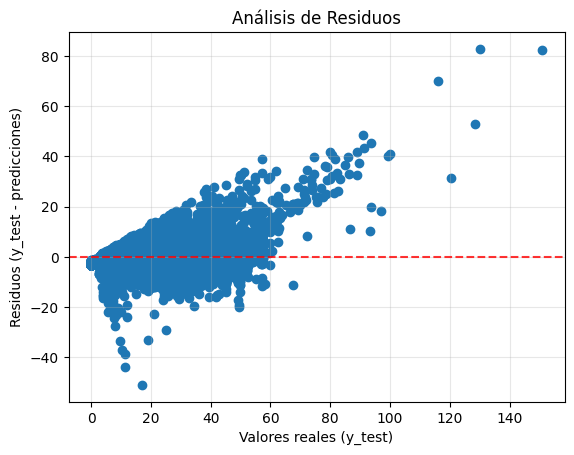

In [79]:
graficos_residuos(y_test, y_pred_lasso)

El análisis de residuos muestra que la mayoría de los errores se concentran alrededor de cero, lo que indica que el modelo logra predecir con buena precisión en la mayoría de los casos. Sin embargo, se observan colas largas hacia ambos lados, lo que refleja la presencia de algunos valores atípicos en los que el modelo presenta mayores desviaciones. Esto sugiere un buen ajuste general, aunque con margen de mejora en la predicción de casos extremos.

El gráfico de residuos muestra que, si bien la mayoría de las predicciones se concentran alrededor de la línea de referencia, existe un patrón de dispersión que aumenta a medida que crecen los valores reales. Esto indica que el modelo tiende a subestimar los valores altos y a sobreestimar algunos valores bajos, generando mayor error en casos extremos. Aunque el ajuste es razonable en la región central, se evidencia cierta heterocedasticidad que refleja un desempeño desigual según el rango de la variable objetivo.

In [80]:
rmse_lasso = np.sqrt(mean_squared_error(
                    y_true  = y_test,
                    y_pred  = y_pred_lasso
                    ))

print(f"El error (rmse) de test es: {rmse_lasso}")

El error (rmse) de test es: 3.5181450121456646


In [81]:
R2_lasso = metrics.r2_score(y_test, y_pred_lasso)

print(f'R2 en el modelo después de Lasso Regression: {R2_lasso}')

R2 en el modelo después de Lasso Regression: 0.8621451046816986


### Ridge Regression

In [82]:
modelo_ridge = make_pipeline(StandardScaler(),
                        RidgeCV(
                           alphas = np.logspace(-3, 8, 500),
                           fit_intercept = True,
                           cv = 10
                        )
         )

_ = modelo_ridge.fit(X_train, y_train)

mod_ridge = modelo_ridge.steps[1][1]

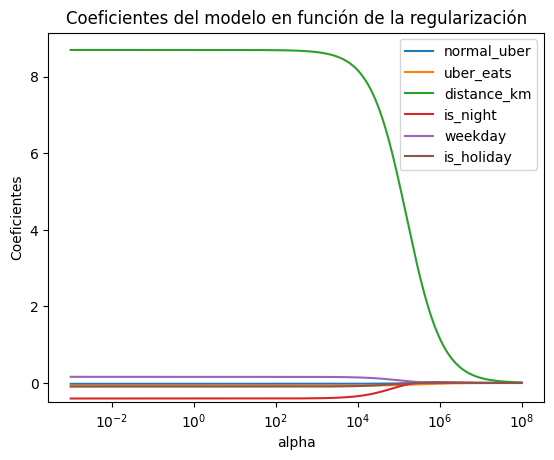

In [83]:
alphas_ridge = mod_ridge.alphas
coefs_ridge = []

for alpha in alphas_ridge:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs_ridge.append(modelo_aux.steps[1][1].coef_.flatten())

grafico_coef_regularizacion(alphas_ridge, coefs_ridge, X_train.columns)

En este gráfico se observa nuevamente el efecto de la regularización sobre los coeficientes del modelo. La variable más influyente es la distancia en kilómetros, que mantiene un valor alto incluso con distintos niveles de regularización, aunque disminuye de forma marcada cuando alpha crece en exceso. El resto de las variables presentan coeficientes muy cercanos a cero.

In [84]:
print(f"Mejor valor de alpha encontrado: {mod_ridge.alpha_}")

Mejor valor de alpha encontrado: 10.280732238308648


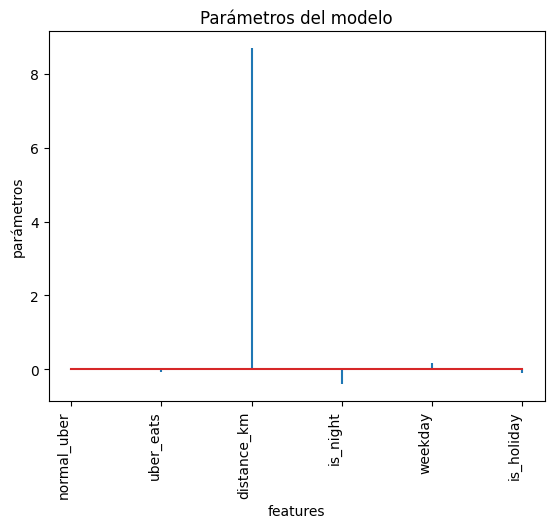

In [85]:
df_coeficientes_ridge = pd.DataFrame({
                                      'predictor': X_train.columns,
                                      'coef': mod_ridge.coef_.flatten()
                                      })

grafico_coef(df_coeficientes_ridge)

Gráfico idéntico al uno anterior. Cito:

"El gráfico de parámetros del modelo muestra que la variable con mayor peso es la distancia en kilómetros, con un coeficiente significativamente más alto que el resto. Las demás variables presentan valores muy cercanos a cero, lo que refleja un impacto mínimo en las predicciones. Esto confirma que la distancia es el factor principal que determina el resultado del modelo, mientras que las otras características aportan de manera marginal."

In [86]:
y_pred_ridge = modelo_ridge.predict(X_test)

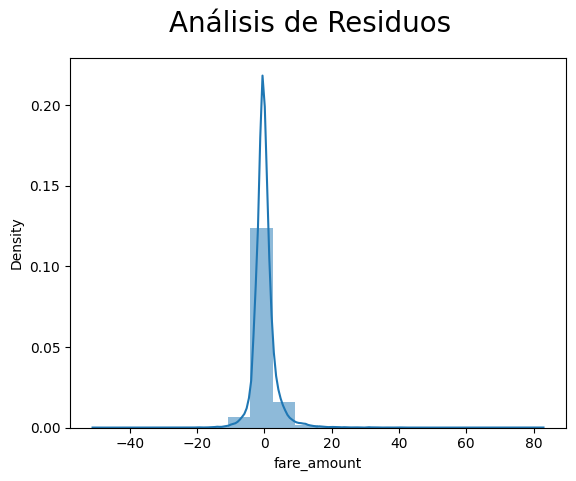

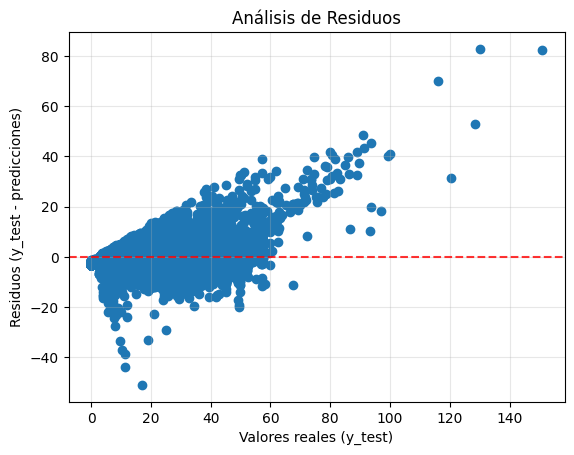

In [87]:
graficos_residuos(y_test, y_pred_ridge)

Gráficos idénticos a anteriorer, cito:

"El análisis de residuos muestra que la mayoría de los errores se concentran alrededor de cero, lo que indica que el modelo logra predecir con buena precisión en la mayoría de los casos. Sin embargo, se observan colas largas hacia ambos lados, lo que refleja la presencia de algunos valores atípicos en los que el modelo presenta mayores desviaciones. Esto sugiere un buen ajuste general, aunque con margen de mejora en la predicción de casos extremos.

El gráfico de residuos muestra que, si bien la mayoría de las predicciones se concentran alrededor de la línea de referencia, existe un patrón de dispersión que aumenta a medida que crecen los valores reales. Esto indica que el modelo tiende a subestimar los valores altos y a sobreestimar algunos valores bajos, generando mayor error en casos extremos. Aunque el ajuste es razonable en la región central, se evidencia cierta heterocedasticidad que refleja un desempeño desigual según el rango de la variable objetivo."

In [88]:
rmse_ridge = np.sqrt(mean_squared_error(
                    y_true  = y_test,
                    y_pred  = y_pred_ridge
                    ))

print(f"El error (rmse) de test es: {rmse_ridge}")

El error (rmse) de test es: 3.5181658779213882


In [89]:
R2_ridge = metrics.r2_score(y_test, y_pred_ridge)

print(f'R2 en el modelo después de Ridge Regression: {R2_ridge}')

R2 en el modelo después de Ridge Regression: 0.86214346946891


### Elastic Net

In [90]:
modelo_elasticnet = make_pipeline(StandardScaler(),
                        ElasticNetCV(
                              l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas = np.logspace(-3, 6, 200),
                              cv = 10
                           )
         )

_ = modelo_elasticnet.fit(X_train, y_train)

mod_elasticnet = modelo_elasticnet.steps[1][1]

c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning:

Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.

c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.171e+06, tolerance: 1.234e+03

c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning:

Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.

c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_d

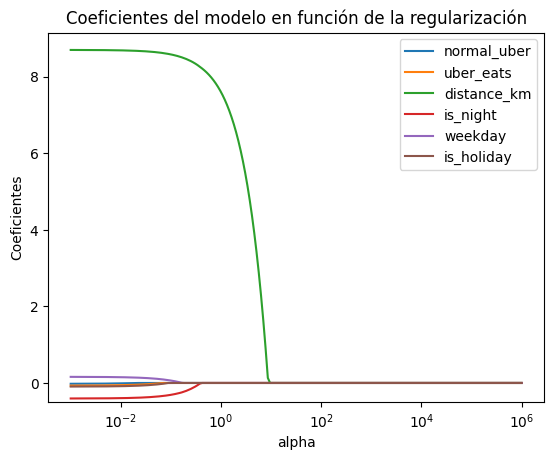

In [91]:
alphas_elastic = mod_elasticnet.alphas
coefs_elastic = []

for alpha in alphas_elastic:
    modelo_aux = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha=alpha, l1_ratio=0.99, max_iter=10000)
    )
    modelo_aux.fit(X_train, y_train)
    coefs_elastic.append(modelo_aux.steps[1][1].coef_.flatten())

grafico_coef_regularizacion(alphas_elastic, coefs_elastic, X_train.columns)

En este gráfico se analiza cómo varían los coeficientes del modelo en función del parámetro de regularización. Se observa que distance_km mantiene un coeficiente alto y positivo mientras la regularización es baja, pero a medida que aumenta alpha, su valor se reduce de forma drástica hasta acercarse a cero

In [92]:
print(f"Mejor valor de alpha encontrado: {mod_elasticnet.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod_elasticnet.l1_ratio_}")

Mejor valor de alpha encontrado: 0.001
Mejor valor de l1_ratio encontrado: 0.99


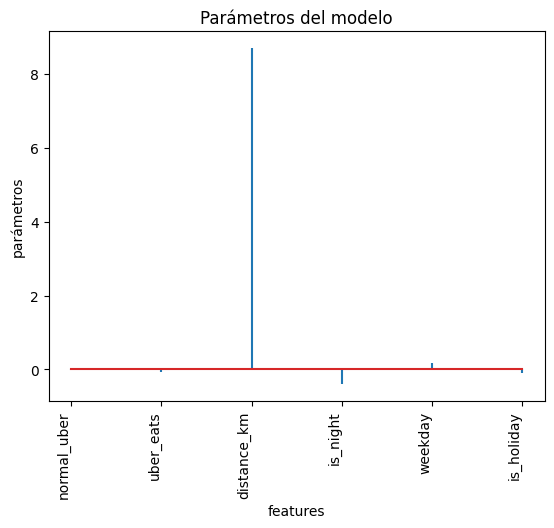

In [93]:
df_coeficientes_elastic = pd.DataFrame(
                            {'predictor': X_train.columns,
                            'coef': mod_elasticnet.coef_.flatten()}
                          )

grafico_coef(df_coeficientes_elastic)

Gráfico idéntico al uno anterior. Cito:

"El gráfico de parámetros del modelo muestra que la variable con mayor peso es la distancia en kilómetros, con un coeficiente significativamente más alto que el resto. Las demás variables presentan valores muy cercanos a cero, lo que refleja un impacto mínimo en las predicciones. Esto confirma que la distancia es el factor principal que determina el resultado del modelo, mientras que las otras características aportan de manera marginal."

In [94]:
y_pred_elastic = modelo_elasticnet.predict(X_test)

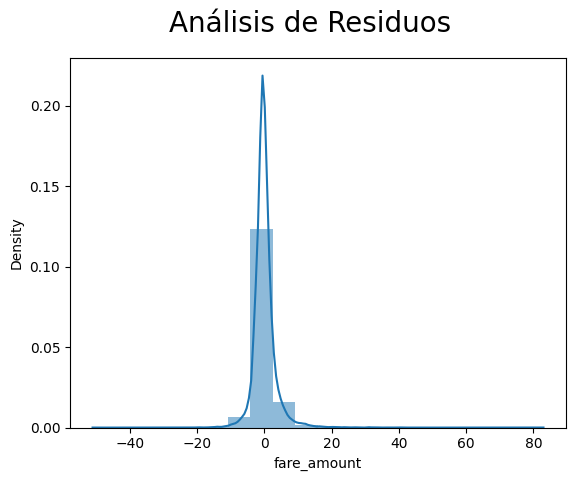

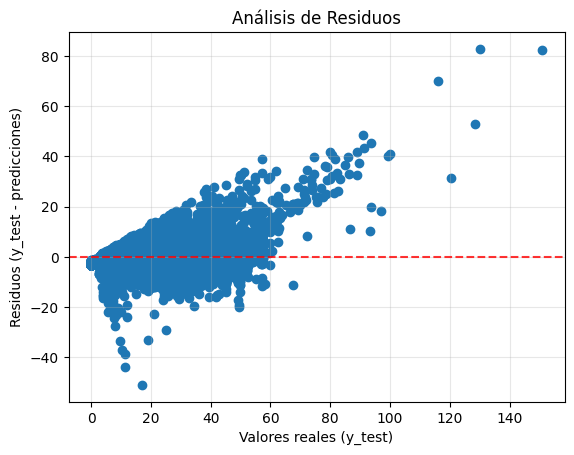

In [95]:
graficos_residuos(y_test, y_pred_elastic)

Gráficos idénticos a anteriorer, cito:

"El análisis de residuos muestra que la mayoría de los errores se concentran alrededor de cero, lo que indica que el modelo logra predecir con buena precisión en la mayoría de los casos. Sin embargo, se observan colas largas hacia ambos lados, lo que refleja la presencia de algunos valores atípicos en los que el modelo presenta mayores desviaciones. Esto sugiere un buen ajuste general, aunque con margen de mejora en la predicción de casos extremos.

El gráfico de residuos muestra que, si bien la mayoría de las predicciones se concentran alrededor de la línea de referencia, existe un patrón de dispersión que aumenta a medida que crecen los valores reales. Esto indica que el modelo tiende a subestimar los valores altos y a sobreestimar algunos valores bajos, generando mayor error en casos extremos. Aunque el ajuste es razonable en la región central, se evidencia cierta heterocedasticidad que refleja un desempeño desigual según el rango de la variable objetivo."

In [96]:
rmse_elacticnet = np.sqrt(mean_squared_error(
                    y_true  = y_test,
                    y_pred  = y_pred_elastic
                    ))

print(f"El error (rmse) de test es: {rmse_elacticnet}")

El error (rmse) de test es: 3.5181465728696826


In [97]:
R2_elastic = metrics.r2_score(y_test, y_pred_elastic)
print(f'R2 en el modelo después de ElasticNet: {R2_elastic}')

R2 en el modelo después de ElasticNet: 0.8621449823709393


### Comparación de modelos

Comparación según RMSE
             modelo  test rmse
0  LinearRegression   3.518156
1             Ridge   3.518166
2             Lasso   3.518145
3       Elastic-net   3.518147
Comparación según R2
             modelo   test R2
0  LinearRegression  0.862144
1             Ridge  0.862143
2             Lasso  0.862145
3       Elastic-net  0.862145


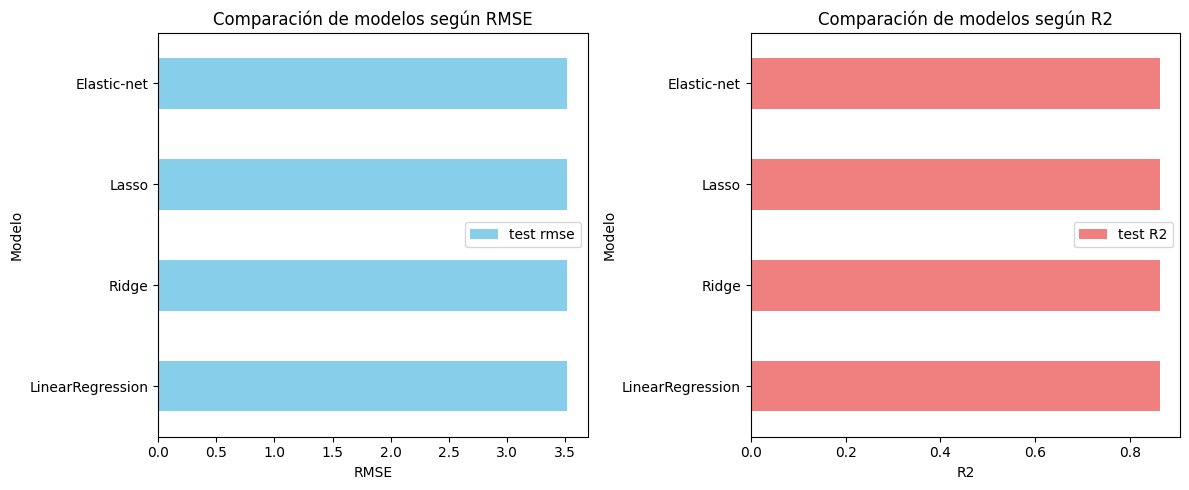

In [98]:
df_comparacion_rmse = pd.DataFrame({
                        'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                        'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elacticnet]
                     })

df_comparacion_R2 = pd.DataFrame({
                     'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                     'test R2': [R2, R2_ridge, R2_lasso, R2_elastic]
                  })

print('Comparación según RMSE')
print(df_comparacion_rmse)

print('Comparación según R2')
print(df_comparacion_R2)

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Gráfico RMSE
df_comparacion_rmse.set_index('modelo').plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_xlabel('RMSE')
ax1.set_ylabel('Modelo')
ax1.set_title('Comparación de modelos según RMSE')
# Gráfico R2
df_comparacion_R2.set_index('modelo').plot(kind='barh', ax=ax2, color='lightcoral')
ax2.set_xlabel('R2')
ax2.set_ylabel('Modelo')
ax2.set_title('Comparación de modelos según R2')

plt.tight_layout()
plt.show()

En esta comparación de modelos evaluamos el desempeño según dos métricas: RMSE (error cuadrático medio de raíz) y R² (capacidad explicativa del modelo).

En el gráfico de la izquierda, los valores de RMSE son prácticamente iguales para los cuatro modelos: Linear Regression, Ridge, Lasso y Elastic Net, todos cercanos a 3.5. Esto indica que en términos de error absoluto, ninguno aporta una mejora significativa sobre el resto.

En el gráfico de la derecha, con la métrica R², ocurre lo mismo: los valores están muy próximos entre sí y cercanos a 0.85, lo que refleja un buen nivel de ajuste del modelo, pero sin diferencias claras que justifiquen la elección de uno sobre otro.

## Conclusión

En este trabajo se entrenaron distintos modelos de regresión lineal con el objetivo de predecir el precio de un viaje en Uber (en el Estado de Nueva York, Estados Unidos), teniendo en cuenta distintos parámetros como la distancia recorrida, el horario, el tipo de Uber, el día de la semana y los feriados. Los rendimientos de estos modelos fueron comparados utilizando métricas de error (RMSE) y coeficiente de determinación (R²).

Se evaluaron tres variantes de optimización por gradiente (batch, estocástico y mini-batch) y métodos de regularización (Ridge, Lasso y Elastic-net). Sin embargo, desde el primer modelo evaluado se visualizó una precisión muy alta2, la cual no presenta mejoras significativas al aplicar estos métodos.

Los resultados muestran que:

- **Regresión lineal estándar:** El modelo básico ya presenta un desempeño alto, con R² ≈ 0.862 y RMSE ≈ 3.518, indicando que captura correctamente la mayor parte de la variabilidad en los datos.

- **Gradiente descendente:** El gradiente descendente estándar y el mini-batch presentan métricas muy similares al modelo original (RMSE ≈ 3.55, R² ≈ 0.859). Por su parte, el gradiente estocástico mostró un rendimiento significativamente inferior (RMSE ≈ 4.53, R² ≈ 0.77), probablemente debido a la alta variabilidad inherente a los pasos individuales del entrenamiento.

- **Regularización:** La incorporación de estas técnicas no produjo mejoras sustanciales en las métricas respecto a la regresión lineal estándar, dado que todas las variantes presentaron RMSE y R² prácticamente idénticos (RMSE ≈ 3.518, R² ≈ 0.862). Esto sugiere que el conjunto de datos no presenta problemas significativos de multicolinealidad o sobreajuste que requieran regularización.

En resumen, para este conjunto de datos, la regresión lineal simple es suficiente para modelar la relación entre las variables y el precio de los viajes. Las técnicas de optimización por gradiente y regularización, aunque útiles en otros contextos, no aportan ventajas adicionales en este caso.